#Retinal Disease Classification using Deep Neural Networks

#Import Libraries

In [ ]:
import os
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import itertools
import scipy
import skimage
import torch
import tensorflow as tf
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from tensorflow.keras import optimizers
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from keras.applications.mobilenet import MobileNet
from keras.utils.np_utils import to_categorical
from sklearn.metrics import roc_auc_score, roc_curve, auc
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")

# Mount Google drive on to Collab workspace

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/MyDrive/'

/content/drive/MyDrive


In [ ]:
# Checking if CUDA is available
flag_cuda = torch.cuda.is_available()

if not flag_cuda:
    print('Using CPU')
else:
    print('Using GPU')

Using GPU


# Loading Dataset from the drive

User is expected to download and store the data in google drive as per the specified location. Create an empty folder in the drive as '759SWProject', such that the path to the folder can be given as -> "MyDrive/759SWProject/"

Link for dataset download -> https://www.kaggle.com/datasets/paultimothymooney/kermany2018

Download OCT2017 folder from above given link and save the folder inside '759SWProject' folder in the google drive.

In [ ]:
from sklearn.model_selection import train_test_split
img_size = 150
main_dir = os.listdir('759SWProject/OCT2017/')
def load_data():
    
    images = []
    labels = []
    label = 0
    for i in main_dir:
        print ("Loading ",str(i), "data...!!!")
        dataset_dir_list = os.listdir('759SWProject/OCT2017/' + str(i) + '/')
        for j in dataset_dir_list:   
            print(str(j))           
            img_dir_list = os.listdir('759SWProject/OCT2017/' + str(i) + '/' + str(j) + '/')
       
            if len(img_dir_list) > 2500:
                img_dir_list = img_dir_list[:2500]
                
            if j in ['DRUSEN']: label = 0
            elif j in ['CNV']: label = 1
            elif j in ['NORMAL']: label = 2
            elif j in ['DME']: label = 3

            for k in img_dir_list:
                input_img = cv2.imread('759SWProject/OCT2017/' + str(i)+ '/'+ str(j) + '/'+ str(k))
                # Normalize image
                input_img = input_img/255
                resized_img = skimage.transform.resize(input_img,(img_size,img_size,3))
                img_arr = np.asarray(resized_img)
                images.append(img_arr)
                labels.append(label)
                
    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')
    
    X_train, X_test, y_train, y_test = train_test_split(images, labels,test_size=0.3)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_data()

y_trainHot = to_categorical(y_train, num_classes = 4)
y_testHot = to_categorical(y_test, num_classes = 4)

Loading  test data...!!!
NORMAL
CNV
DME
DRUSEN
Loading  train data...!!!
cnv
normal
drusen
dme


#Helper functions to visualize data and results

In [ ]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

# Function to plot the graph of Accuracy Vs Epochs. Accuracy is expected to increase as number of epoch increases.
def plotKerasLearningCurve_accuracy():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy',allow_pickle=True)[()]
    filt = ['acc']
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.show()

# Function to plot the graph of loss Vs Epochs. Loss is expected to decrease as number of epoch increases.
def plotKerasLearningCurve_Loss():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy',allow_pickle=True)[()]
    filt = ['loss'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')
    plt.show()

# Function to plot Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Function to plot the accuracy and loss function of training and test data

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.show()

#Transfer Learning from VGG16 and InceptionV3 (standard CNN architectures for classification trained on ImageNet Dataset

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

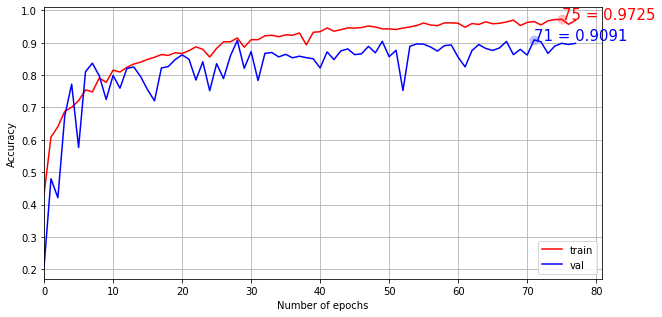

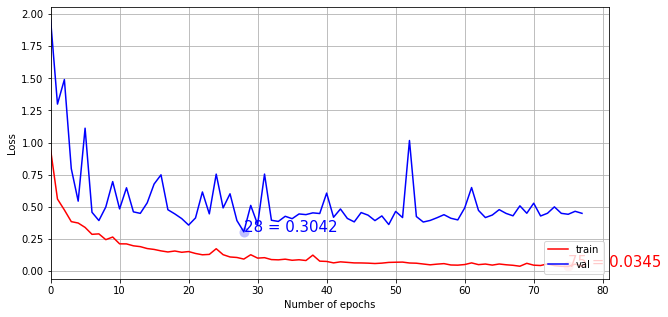

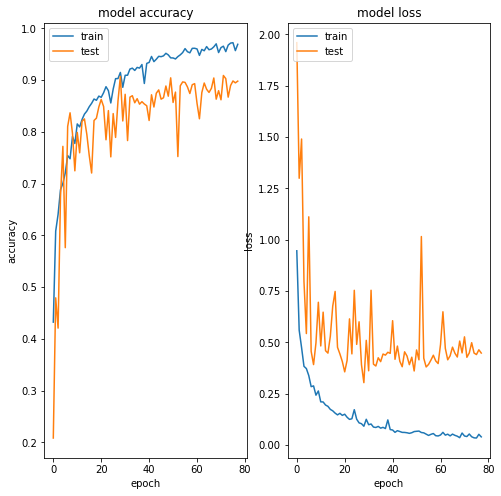

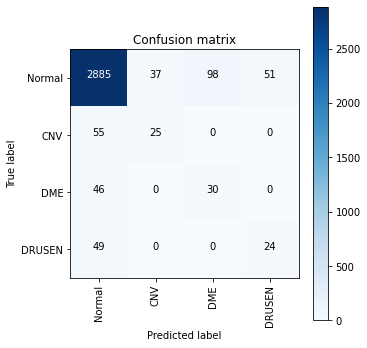

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
imageSize=150
map_characters1 = {0: 'Normal', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}
class_weight1 = class_weight.compute_class_weight(
                                                    'balanced', 
                                                    classes = np.unique(y_train),
                                                    y = y_train
                                                  )
class_weight1 = dict(zip(np.unique(y_train), class_weight1))
weight_path1 = '759SWProject/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
weight_path2 = '759SWProject/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained_model_1 = VGG16(weights = weight_path1, include_top=False, input_shape=(imageSize, imageSize, 3))
pretrained_model_2 = InceptionV3(weights = weight_path2, include_top=False, input_shape=(imageSize, imageSize, 3))
optimizer1 = tf.keras.optimizers.Adam()
optimizer2 = tf.keras.optimizers.RMSprop(lr=0.0001)
def pretrainedNetwork(xtrain,ytrain,xtest,ytest,pretrainedmodel,pretrainedweights,classweight,numclasses,numepochs,optimizer,labels):
    base_model = pretrained_model_1 # Topless
    # Add top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(numclasses, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    # Fit model
    history = model.fit(xtrain,ytrain, epochs=numepochs, class_weight=classweight, validation_data=(xtest,ytest), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    # Evaluate model
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    # Predict on test dataset
    y_pred = model.predict(xtest)
    print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(ytest,axis = 1) 
    # Compute Confusion Matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    # Plot model accuracy for training data and validation data versus number of epochs trained
    plotKerasLearningCurve_accuracy()
    # Plot loss function for training data and validation data versus number of epochs trained
    plotKerasLearningCurve_Loss()
    # Plot model accuracy and loss for training and test dataset
    plot_learning_curve(history)
    # Plot confusion matrix
    plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
    plt.show()
    return model

# VGG16 Model trained with Adam optimizer
pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_1,weight_path1,class_weight1,4,78,optimizer1,map_characters1)

Inception V3 Model trained with Adam optimizer.

Epochs trained - 100

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

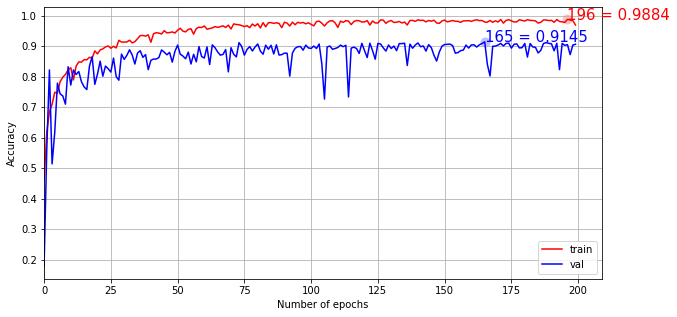

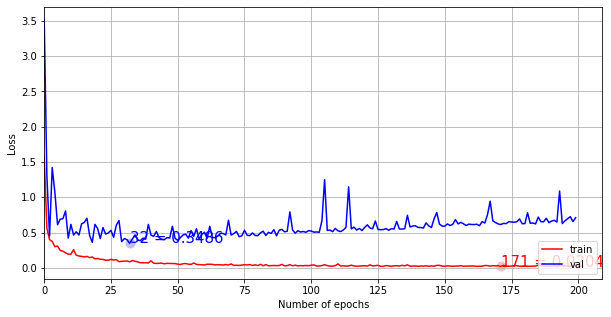

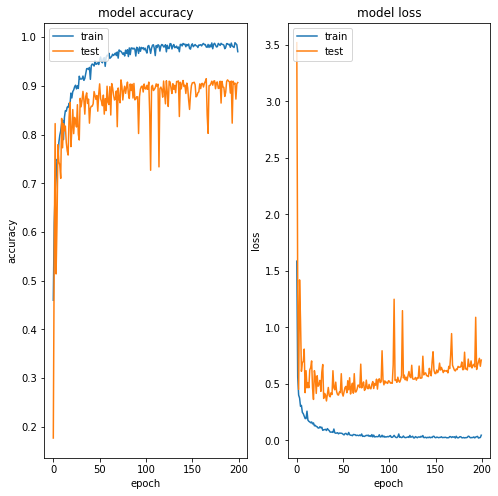

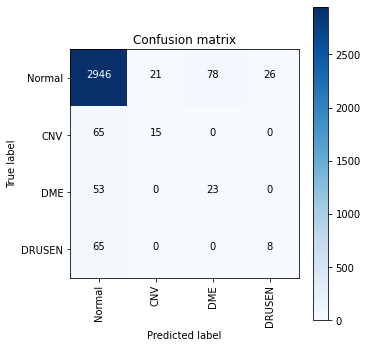

In [ ]:
pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_2,weight_path2,class_weight1,4,200,optimizer1,map_characters1)

Inception V3 Model trained with RMS Prop optimizer.

Epoch trained - 100

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

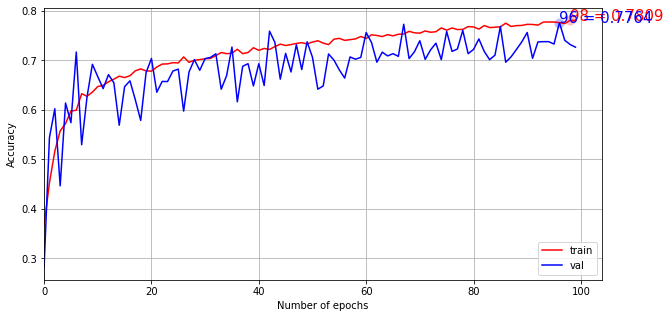

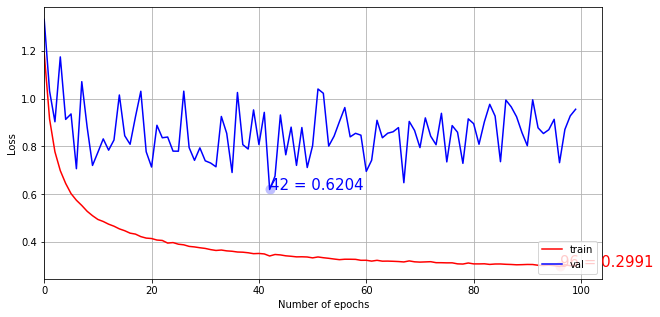

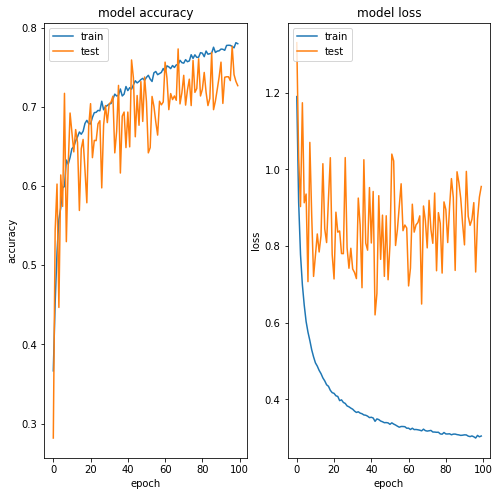

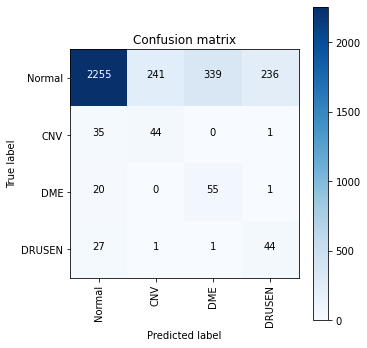

In [ ]:
pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_2,weight_path2,class_weight1,4,100,optimizer2,map_characters1)

VGG16 Model trained with RMS Prop optimizer.

Epochs trained - 100

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

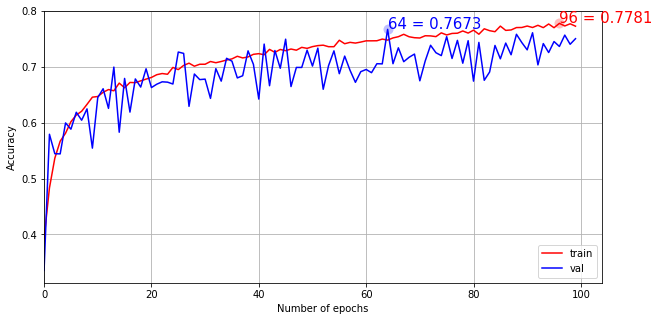

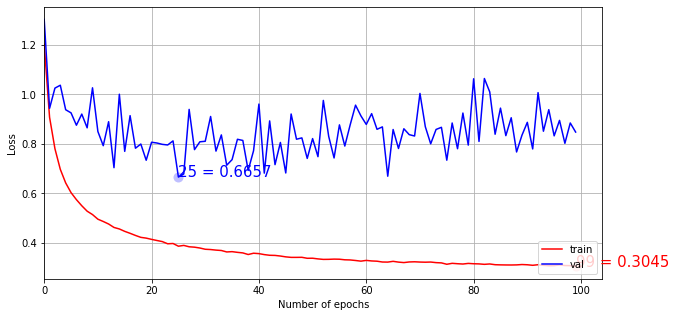

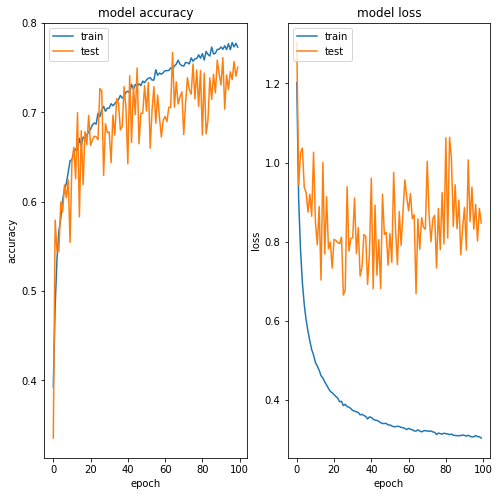

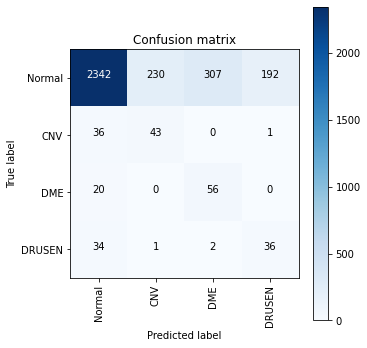

In [ ]:
pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_1,weight_path1,class_weight1,4,100,optimizer2,map_characters1)

Generate requirements for this notebook

In [ ]:
!pip freeze > requirements.txt